In [1]:
import collections
import json
import datetime
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tqdm

# Data Imports

In [2]:
language = "r"
path_to_lib = f"data/results/{language}"

In [3]:
with open(f"{path_to_lib}/{language}_{language}_daily_post_stats.json") as handle:
    daily_post_count = json.load(handle)

with open(f"{path_to_lib}/{language}_post_to_libs.json") as handle:
    post_to_libs = json.load(handle)

with open(f"{path_to_lib}/{language}_libs_count.json") as handle:
    libs_count = json.load(handle)
    
with open(f"{path_to_lib}/{language}_pairs_count.json") as handle:
    pairs_count = json.load(handle)
    
with open(f"{path_to_lib}/{language}_all_libs_dates.json") as handle:
    all_libs_dates = json.load(handle)
    
with open(f"{path_to_lib}/{language}_all_pairs_dates.json") as handle:
    all_pairs_dates = json.load(handle)
    
with open(f"{path_to_lib}/{language}_libs_first_dates.json") as handle:
    libs_first_dates = json.load(handle)
    
with open(f"{path_to_lib}/{language}_pairs_first_dates.json") as handle:
    pairs_first_dates = json.load(handle)

# New libs and pairs (y axis) against post count (x axis)

In [4]:
t0 = time.time()
xs_libs = [d[0] for d in post_to_libs['distinct_libs_plot']]
ys_libs = [d[1] for d in post_to_libs['distinct_libs_plot']]
xs_pairs = [d[0] for d in post_to_libs['distinct_pairs_plot']]
ys_pairs = [d[1] for d in post_to_libs['distinct_pairs_plot']]
t1 = time.time()
print(f"Segments formed (took {round(t1 - t0, 2)} seconds).")

# Unique libs line fit
libs_a, libs_b  = np.polyfit(range(len(xs_libs)), ys_libs, 1)
pairs_a, pairs_b = np.polyfit(range(len(xs_pairs)), ys_pairs, 1)
t2 = time.time()
print(f"Fits performed (took {round(t2 - t1, 2)} seconds).")

Segments formed (took 0.05 seconds).
Fits performed (took 0.1 seconds).


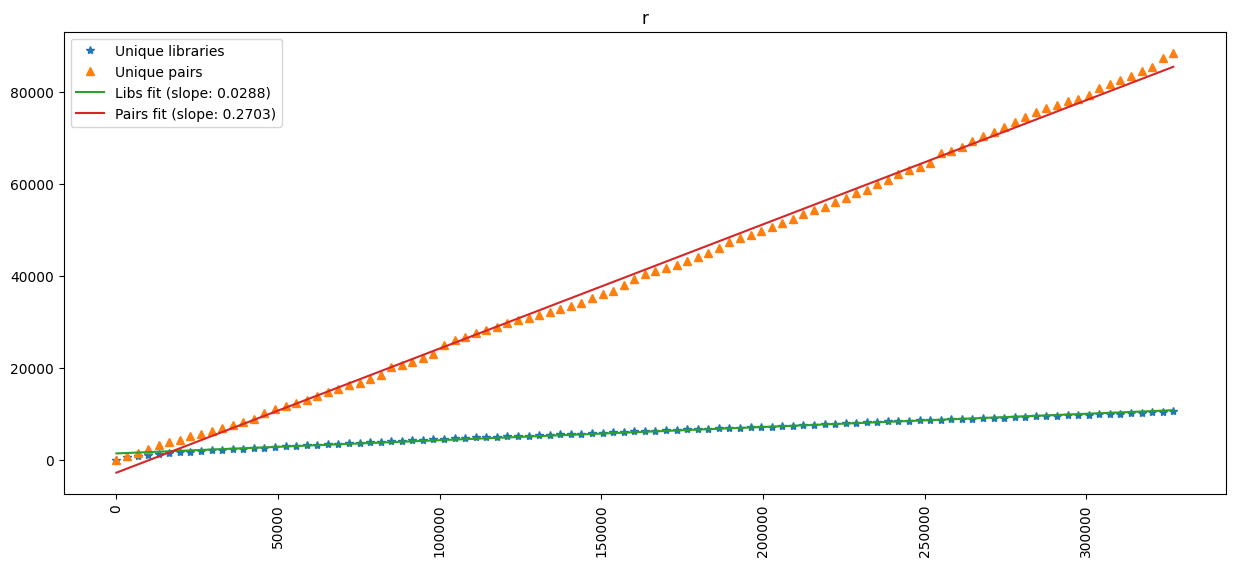

In [5]:
step_size = len(xs_libs) // 100

plt.figure(figsize=(15,6))

plt.plot(range(0, len(xs_libs), step_size), ys_libs[::step_size], "*", label="Unique libraries")
plt.plot(range(0, len(xs_pairs), step_size), ys_pairs[::step_size], "^", label="Unique pairs")

plt.plot(range(0, len(xs_libs), step_size), [libs_a * x + libs_b for x in range(len(xs_libs))][::step_size], label=f"Libs fit (slope: {round(libs_a,4)})")
plt.plot(range(0, len(xs_pairs), step_size), [pairs_a * x + pairs_b for x in range(len(xs_pairs))][::step_size], label=f"Pairs fit (slope: {round(pairs_a, 4)})")
plt.title(language)
plt.xticks(rotation=90)
plt.legend(loc="upper left")
#plt.loglog()

# Post count, lib count, pair count (y axis) against time (x axis)

In [6]:
def get_time_buckets(start, end, default_value=0):
    time_buckets = {}
    runner = datetime.datetime(*[int(item) for item in start.split("-")])
    delta = datetime.timedelta(days=1)
    while runner < datetime.datetime(*[int(item) for item in end.split("-")]):
        time_buckets[runner.strftime("%Y-%m-%d")] = default_value
        runner += delta
    return time_buckets

In [7]:
start = "2008-1-1"
end =  "2024-1-1"


xs = list(get_time_buckets(start, end).keys())

libs_buckets = get_time_buckets(start, end)
for v in libs_first_dates.values():
    libs_buckets[v["date"]] += 1
libs_ys = list(pd.Series(libs_buckets).cumsum())

pairs_buckets = get_time_buckets(start, end)
for v in pairs_first_dates.values():
    pairs_buckets[v["date"]] += 1
pairs_ys = list(pd.Series(pairs_buckets).cumsum())

post_counts_buckets =  get_time_buckets(start, end)
post_counts_buckets.update({
    k: v for k, v in daily_post_count.items() if
    datetime.datetime.strptime(start, "%Y-%m-%d") <= datetime.datetime.strptime(k, "%Y-%m-%d") < datetime.datetime.strptime(end, "%Y-%m-%d")
})
post_counts_ys = list(pd.Series(post_counts_buckets).cumsum())

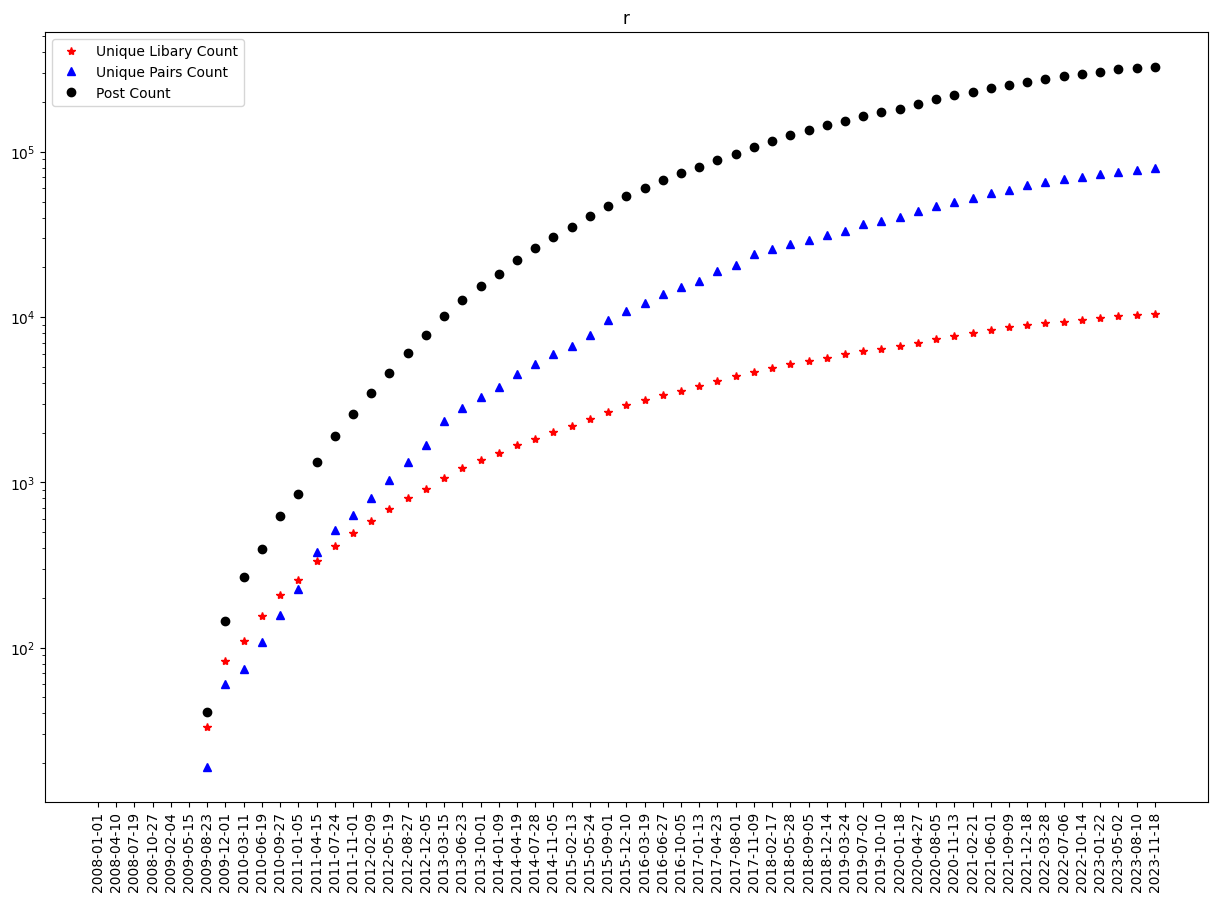

In [8]:
step_size = 100

plt.figure(figsize=(15,10))

plt.plot(xs[::step_size], libs_ys[::step_size], "r*", label="Unique Libary Count")
plt.plot(xs[::step_size], pairs_ys[::step_size], "b^", label="Unique Pairs Count")
plt.plot(xs[::step_size], post_counts_ys[::step_size], "ko", label="Post Count")
plt.title(language)
plt.xticks(rotation=90)
plt.semilogy()
plt.legend(loc="upper left")

# Frequency of libs spread across the years (x axis)

In [9]:
start = "2008-1-1"
end =  "2024-1-1"
delta = datetime.timedelta(days=365)
rolling_window = 30

xs = list(get_time_buckets(start, end))

scatters_x, scatters_y = [],  []
avg = collections.defaultdict(list)
# only checking number of uses in the year following the first appearance
for lib_name, first_appeared in tqdm.tqdm(libs_first_dates.items()):
    first_appeared_dt = datetime.datetime.strptime(first_appeared["date"], "%Y-%m-%d")
    usage_cnt = len(
        [dt for dt in all_libs_dates[lib_name]
         if first_appeared_dt <= datetime.datetime.strptime(dt, "%Y-%m-%d")  < first_appeared_dt + delta]
    )
    scatters_x.append(first_appeared_dt)
    scatters_y.append(usage_cnt)
    avg[first_appeared_dt.strftime("%Y-%m-%d")].append(usage_cnt)

df = pd.DataFrame(avg.items(), columns=['dates', 'counts'])
df['dates_dt'] = df.dates.apply(lambda dt: datetime.datetime.strptime(dt, "%Y-%m-%d"))
df['averages'] = df.counts.apply(lambda row: sum(row) / len(row))
df['roller'] = df.averages.rolling(rolling_window).mean()


100%|█| 10478/10478 [00:02<00:00, 3


[]

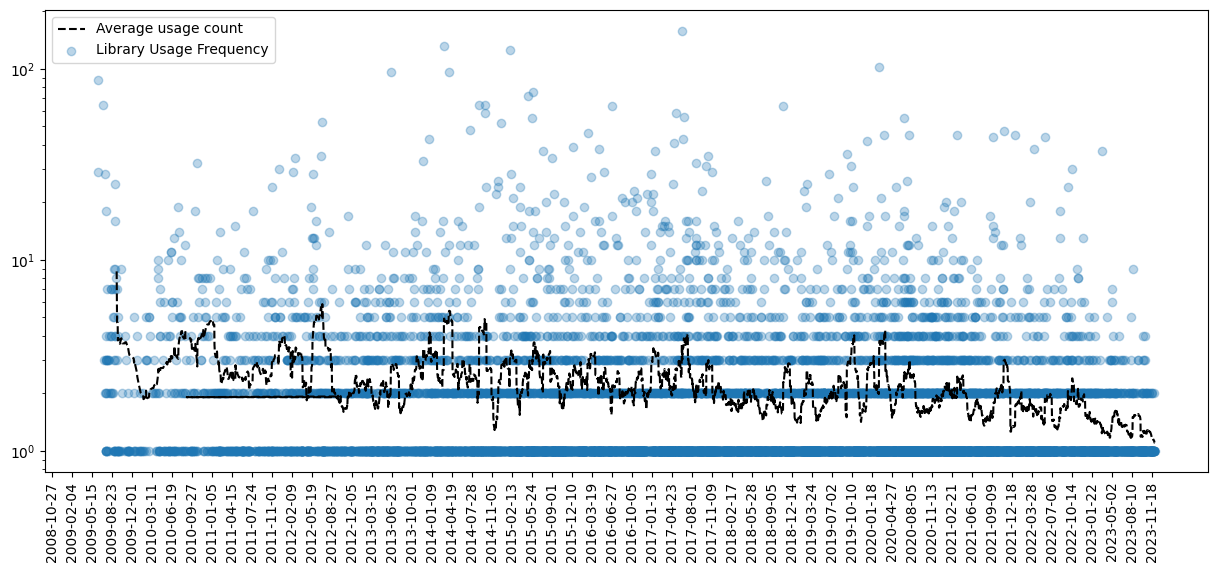

In [10]:
plt.figure(figsize=(15,6))
plt.plot(list(df.dates_dt),list(df.roller), "k--", label="Average usage count")
plt.scatter(scatters_x, scatters_y, alpha=0.3, label="Library Usage Frequency")
plt.xticks(xs[::100], rotation=90)
plt.legend(loc="upper left")
plt.semilogy()


# !!! CONSTRUCTION SITE !!!

In [11]:
len(xs_pairs), len(ys_pairs)

(326975, 326975)

In [12]:
xs_pairs

['2009-06-14T17:36:56.153',
 '2009-07-11T21:55:28.490',
 '2009-07-17T09:35:57.180',
 '2009-07-17T13:10:54.090',
 '2009-07-20T15:43:54.380',
 '2009-07-22T19:12:25.030',
 '2009-07-23T02:56:09.883',
 '2009-07-23T03:23:00.350',
 '2009-07-23T03:31:37.633',
 '2009-07-23T04:22:58.433',
 '2009-07-23T04:30:39.980',
 '2009-07-23T04:55:41.253',
 '2009-07-23T08:04:13.713',
 '2009-07-23T19:22:01.963',
 '2009-07-24T11:32:35.753',
 '2009-07-25T03:07:18.407',
 '2009-07-25T22:51:54.827',
 '2009-07-26T11:18:07.383',
 '2009-07-27T21:54:20.460',
 '2009-07-28T04:34:51.780',
 '2009-07-28T06:29:20.270',
 '2009-07-29T01:36:14.977',
 '2009-07-29T05:26:13.953',
 '2009-07-31T19:30:45.027',
 '2009-08-02T20:35:28.767',
 '2009-08-05T15:18:21.357',
 '2009-08-06T21:20:48.533',
 '2009-08-06T22:51:49.503',
 '2009-08-10T09:52:11.657',
 '2009-08-10T18:51:22.337',
 '2009-08-11T14:22:44.977',
 '2009-08-11T15:54:00.537',
 '2009-08-13T19:46:34.550',
 '2009-08-19T03:35:02.050',
 '2009-08-19T12:14:46.097',
 '2009-08-19T15:44:3

In [13]:
[item[0] for item in sorted(pairs_first_dates.items(), key=lambda x: x[1]['date'])]

['ggplot2|reshape',
 'ggplot2|lattice',
 'R2HTML|svIDE',
 'R2HTML|svIO',
 'R2HTML|svSocket',
 'R2HTML|utils',
 'svIDE|svIO',
 'svIDE|svSocket',
 'svIDE|utils',
 'svIO|svSocket',
 'svIO|utils',
 'svSocket|utils',
 'lattice|reshape',
 'lattice|zoo',
 'reshape|zoo',
 'help=mediation|mediation',
 'coin|multcomp',
 'chron|plyr',
 'caTools|fields',
 'CarbonEL|RColorBrewer',
 'CarbonEL|grDevices',
 'CarbonEL|plyr',
 'CarbonEL|stringr',
 'RColorBrewer|grDevices',
 'RColorBrewer|plyr',
 'RColorBrewer|stringr',
 'grDevices|plyr',
 'grDevices|stringr',
 'plyr|stringr',
 'Hmisc|sqldf',
 'ggplot|ggplot2',
 'ggplot|plyr',
 'ggplot2|plyr',
 'foreach|iterators',
 'RColorBrewer|rgdal',
 'RColorBrewer|sp',
 'rgdal|sp',
 'xts|zoo',
 'RCurl|XML',
 'quantmod|xtable',
 'foreign|reshape',
 'brew|tools',
 'MASS|graphics',
 'MASS|stats',
 'graphics|stats',
 'fUtilities|matrixStats',
 'maptools|rgdal',
 'fields|ggplot2',
 'fields|reshape',
 'Hmisc|pastecs',
 'Hmisc|psych',
 'pastecs|psych',
 'grid|lattice',
 'f

In [14]:
libs_first_dates.keys()

dict_keys(['ggplot2', 'reshape', 'plyr', 'e1071', 'lattice', 'CarbonEL', 'zoo', 'network', 'igraph', 'lme4', 'debug', 'nlme', 'kernlab', 'R2HTML', 'svIDE', 'svIO', 'svSocket', 'utils', 'graphics', 'RODBC', 'help=mediation', 'mediation', 'coin', 'multcomp', 'psych', 'chron', 'maptools', 'Matrix', 'caTools', 'fields', 'sqldf', 'Deducer', 'gtools', 'hash', 'RColorBrewer', 'grDevices', 'stringr', 'sm', 'Hmisc', 'ARE.utils', 'RGoogleDocs', 'ggplot', 'tools', 'effects', 'foreach', 'iterators', 'rgdal', 'sp', 'xts', 'RCurl', 'XML', 'Rlab', 'xtable', 'quantmod', 'foreign', 'brew', 'outliers', 'pixmap', 'MASS', 'stats', 'fUtilities', 'matrixStats', 'bipartite', 'reshape2', 'sfsmisc', 'Biostrings', 'pastecs', 'grid', 'forecast', 'fortunes', 'getopt', 'latticeExtra', 'doBy', 'linmod', 'NADA', 'ROCR', 'AnnotationDbi', 'org.Hs.eg.db', 'GO.db', 'formatR', 'urca', 'vars', 'spatial', 'RUnit', 'ctest', 'tikzDevice', 'rgl', 'getopt", quietly=TRUE', 'package=pkg, character.only=TRUE', 'geneplotter', 'gpl